In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import yfinance as yf
import arch
from arch.univariate import Normal as ARCHNormal

from model.PDV import *
from model.data import *

In [2]:
window = 100                        # historical window for PDV
use_log_ratio = False                # whether to use log ratio vs ratio
use_vix_exog = False                 # whether to use VIX as exogenous variable in mean process
n_lags = 5                          # number of lags for log ratio in mean process
res_window = 10                     # number of lags for residuals in volatility process
max_lag = max(n_lags, res_window)
n_sims = 2                          # number of simulations for multi-step forecasting
seed = 123

# Download data

In [3]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [4]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [5]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [6]:
spx_data = pd.read_csv('data/spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('data/vix_data.csv', index_col=0, parse_dates=[0])

In [7]:
data = create_df_from_yf(spx_data, train_start_date, test_start_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [8]:
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting with least squares

In [11]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, window), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)
res.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9944e+00                                    2.02e+02    
       1              2         2.6414e+00      3.35e+00       6.47e+00       3.34e+01    
       2              3         2.2864e+00      3.55e-01       1.93e-02       2.68e+01    
       3              4         2.0963e+00      1.90e-01       8.94e+00       1.55e+01    
       4              7         2.0539e+00      4.24e-02       4.98e-01       2.90e+00    
       5              8         2.0455e+00      8.44e-03       5.68e+00       6.44e+00    
       6              9         2.0413e+00      4.17e-03       6.20e+00       9.60e+00    
       7             10         2.0288e+00      1.25e-02       5.82e+00       5.93e+00    
       8             11         2.0234e+00      5.41e-03       2.00e+00       1.45e+00    
       9             15         2.0228e+00      5.46e-04       1.09e-01       5.54e-01    

array([ 6.49191071e-02, -2.02792399e-02,  5.23609988e+00,  4.46563325e+01,
        1.41075827e+01,  1.37548726e-32,  1.70470047e+01,  1.90411769e-02,
        9.82963474e-01])

In [12]:
evaluate(res.x, data, window)

Mean: 0.0000, Min: -0.1113, Max: 0.1169, MAE: 0.0205, MSE: 0.0007, R^2: 0.8991


# ARMA model on log of ratio residuals (y/y_hat)

In [13]:
preds = predict(*res.x, data, window)
df_preds = data[window-1:].copy()
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds

,r1,r2,vix,preds,residuals,ratio,log_ratio
1995-05-25,-0.000038,1.425612e-09,0.1163,0.123689,-0.007389,0.940263,-0.061596
1995-05-26,-0.009390,8.816395e-05,0.1220,0.137379,-0.015379,0.888052,-0.118725
1995-05-30,-0.000134,1.787569e-08,0.1252,0.132332,-0.007132,0.946104,-0.055403
1995-05-31,0.018582,3.452829e-04,0.1285,0.133654,-0.005154,0.961441,-0.039322
1995-06-01,0.000169,2.844302e-08,0.1221,0.133784,-0.011684,0.912667,-0.091384
...,...,...,...,...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607,0.321573,0.039127,1.121674,0.114822
2018-12-26,0.048403,2.342868e-03,0.3041,0.304236,-0.000136,0.999553,-0.000447
2018-12-27,0.008526,7.269658e-05,0.2996,0.292115,0.007485,1.025624,0.025301
2018-12-28,-0.001242,1.543443e-06,0.2834,0.288627,-0.005227,0.981889,-0.018277


In [14]:
y = df_preds['log_ratio'][:-1] if use_log_ratio else df_preds['ratio'][:-1]
x = df_preds['vix'].shift(-1).dropna() # shift use that time t-1 vix is used to predict residual for time t
if use_vix_exog:
    arma_model = arch.arch_model(y, x, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # with vix as exogenous variable
else:
    arma_model = arch.arch_model(y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
arma_res = arma_model.fit()
arma_res.summary()

Iteration:      1,   Func. Count:     20,   Neg. LLF: 5404523.606089232
Iteration:      2,   Func. Count:     45,   Neg. LLF: 24315675.705297347
Iteration:      3,   Func. Count:     71,   Neg. LLF: 355675.5205392677
Iteration:      4,   Func. Count:     94,   Neg. LLF: 46641.19919669573
Iteration:      5,   Func. Count:    117,   Neg. LLF: 38765.30157497639
Iteration:      6,   Func. Count:    140,   Neg. LLF: 7161.065698571544
Iteration:      7,   Func. Count:    162,   Neg. LLF: 5826.059507442384
Iteration:      8,   Func. Count:    184,   Neg. LLF: 2901787.0073019303
Iteration:      9,   Func. Count:    205,   Neg. LLF: 21527.300971991637
Iteration:     10,   Func. Count:    225,   Neg. LLF: -2787.594732297402
Iteration:     11,   Func. Count:    247,   Neg. LLF: 291.9447687739442
Iteration:     12,   Func. Count:    268,   Neg. LLF: -7635.924534830914
Iteration:     13,   Func. Count:    289,   Neg. LLF: -8727.34446509245
Iteration:     14,   Func. Count:    310,   Neg. LLF: -9970

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - ARCH Model Results                           
==============================================================================
Dep. Variable:              log_ratio   R-squared:                       0.884
Mean Model:                      AR-X   Adj. R-squared:                  0.884
Vol Model:                       ARCH   Log-Likelihood:                10363.6
Distribution:                  Normal   AIC:                          -20691.1
Method:            Maximum Likelihood   BIC:                          -20570.7
                                        No. Observations:                 5936
Date:                Mon, Oct 28 2024   Df Residuals:                     5929
Time:                        15:34:58   Df Model:                            7
                                    Mean Model                                   
=================================================================================
                    coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------------
Const            -0.0133  2.029e-03     -6.554  5.612e-11 [-1.727e-02,-9.319e-03]
log_ratio[1]      0.8194  1.590e-02     51.519      0.000       [  0.788,  0.851]
log_ratio[2]      0.0516  1.778e-02      2.900  3.731e-03   [1.671e-02,8.640e-02]
log_ratio[3] -4.9942e-05  1.761e-02 -2.836e-03      0.998  [-3.457e-02,3.447e-02]
log_ratio[4]  2.9317e-03  1.713e-02      0.171      0.864  [-3.064e-02,3.650e-02]
log_ratio[5]      0.0642  1.465e-02      4.382  1.174e-05   [3.549e-02,9.293e-02]
vix               0.0588  9.466e-03      6.214  5.156e-10   [4.027e-02,7.737e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0182e-03  7.959e-05     12.794  1.780e-37  [8.622e-04,1.174e-03]
alpha[1]       0.0927  2.087e-02      4.441  8.935e-06    [5.179e-02,  0.134]
alpha[2]       0.0426  1.856e-02      2.293  2.185e-02  [6.182e-03,7.894e-02]
alpha[3]       0.0421  1.591e-02      2.646  8.133e-03  [1.092e-02,7.330e-02]
alpha[4]       0.0390  1.908e-02      2.046  4.079e-02  [1.636e-03,7.641e-02]
alpha[5]       0.1364  3.593e-02      3.796  1.470e-04    [6.598e-02,  0.207]
alpha[6]   2.4216e-03  1.448e-02      0.167      0.867 [-2.597e-02,3.081e-02]
alpha[7]       0.0166  1.113e-02      1.491      0.136 [-5.217e-03,3.840e-02]
alpha[8]       0.0000  1.806e-02      0.000      1.000 [-3.541e-02,3.541e-02]
alpha[9]       0.0335  2.166e-02      1.548      0.122 [-8.931e-03,7.596e-02]
alpha[10]      0.0727  2.469e-02      2.943  3.252e-03    [2.427e-02,  0.121]
=============================================================================

Covariance estimator: robust
"""

# Evaluation

In [15]:
full_data = create_df_from_yf(spx_data, train_start_date, test_end_date, vix_df=vix_data, log_return=True)
full_data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475
2022-05-10,0.002455,6.026444e-06,0.3299
2022-05-11,-0.016600,2.755677e-04,0.3256
2022-05-12,-0.001297,1.681703e-06,0.3177


## Predict 1 step ahead using residuals calculated based on actual historical VIX data

In [16]:
preds = predict(*res.x, full_data, window)
df_preds = full_data[window-1:].copy() # remove data used to calculate first PDV prediction
df_preds['vix_shift'] = df_preds['vix'].shift(1) # shift use that time t-1 vix is used to predict residual for time t
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds

,r1,r2,vix,vix_shift,preds,residuals,ratio,log_ratio
1995-05-25,-0.000038,1.425612e-09,0.1163,NaN,0.123689,-0.007389,0.940263,-0.061596
1995-05-26,-0.009390,8.816395e-05,0.1220,0.1163,0.137379,-0.015379,0.888052,-0.118725
1995-05-30,-0.000134,1.787569e-08,0.1252,0.1220,0.132332,-0.007132,0.946104,-0.055403
1995-05-31,0.018582,3.452829e-04,0.1285,0.1252,0.133654,-0.005154,0.961441,-0.039322
1995-06-01,0.000169,2.844302e-08,0.1221,0.1285,0.133784,-0.011684,0.912667,-0.091384
...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.3019,0.350728,-0.003228,0.990797,-0.009246
2022-05-10,0.002455,6.026444e-06,0.3299,0.3475,0.338454,-0.008554,0.974726,-0.025598
2022-05-11,-0.016600,2.755677e-04,0.3256,0.3299,0.349547,-0.023947,0.931490,-0.070970
2022-05-12,-0.001297,1.681703e-06,0.3177,0.3256,0.340538,-0.022838,0.932936,-0.069419


In [17]:
y = df_preds['log_ratio'][1:] if use_log_ratio else df_preds['ratio'][1:] # drop the first row because vix_shift is nan
x = df_preds['vix_shift'][1:]
if use_vix_exog:
    arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
else:
    arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
arma_model_test.distribution = ARCHNormal(seed=seed) # set seed for reproducibility
fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
if use_vix_exog:
    sims = fix_res.forecast(horizon=1, start=df_preds.index[max_lag], method='simulation', simulations=2, align='origin', x=x[:,np.newaxis]) # with vix as exogenous variable
else:
    sims = fix_res.forecast(horizon=1, start=df_preds.index[max_lag], method='simulation', simulations=2, align='origin') # without vix as exogenous variable
print(sims.simulations.values.shape)
log_residuals = sims.simulations.values[:,0,0] if use_log_ratio else np.log(sims.simulations.values[:,0,0]) # (timestep, simulations, horizon)
df_preds['arma_log_ratio'] = np.NaN
df_preds.iloc[max_lag:, df_preds.columns.get_loc('arma_log_ratio')] = log_residuals
df_preds['arma_preds'] = np.exp(df_preds['arma_log_ratio']) * df_preds['preds']
df_preds['arma_residuals'] = df_preds['vix'] - df_preds['arma_preds']
df_preds[max_lag-1:]


/var/folders/nd/wwb7zyc94wsf4ql14n77712h0000gn/T/ipykernel_47569/4085880112.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sims = fix_res.forecast(horizon=1, start=df_preds.index[max_lag], method='simulation', simulations=2, align='origin', x=x[:,np.newaxis]) # with vix as exogenous variable


(6781, 2, 1)


,r1,r2,vix,vix_shift,preds,residuals,ratio,log_ratio,arma_log_ratio,arma_preds,arma_residuals
1995-06-08,-0.001464,2.143835e-06,0.1289,0.1284,0.136857,-0.007957,0.941860,-0.059898,NaN,NaN,NaN
1995-06-09,-0.008318,6.919705e-05,0.1276,0.1289,0.147304,-0.019704,0.866233,-0.143601,-0.177456,0.123352,0.004248
1995-06-12,0.005553,3.083993e-05,0.1191,0.1276,0.138616,-0.019516,0.859207,-0.151746,-0.084783,0.127348,-0.008248
1995-06-13,0.009691,9.392326e-05,0.1129,0.1191,0.133783,-0.020883,0.843901,-0.169720,-0.116287,0.119097,-0.006197
1995-06-14,0.000783,6.133558e-07,0.1129,0.1129,0.132824,-0.019924,0.849996,-0.162523,-0.177954,0.111171,0.001729
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.3019,0.350728,-0.003228,0.990797,-0.009246,0.009941,0.354232,-0.006732
2022-05-10,0.002455,6.026444e-06,0.3299,0.3475,0.338454,-0.008554,0.974726,-0.025598,-0.073459,0.314483,0.015417
2022-05-11,-0.016600,2.755677e-04,0.3256,0.3299,0.349547,-0.023947,0.931490,-0.070970,-0.087367,0.320305,0.005295
2022-05-12,-0.001297,1.681703e-06,0.3177,0.3256,0.340538,-0.022838,0.932936,-0.069419,-0.025049,0.332114,-0.014414


In [18]:
df_preds['arma_log_ratio'].sum(), df_preds['log_ratio'].sum(), np.abs(df_preds['arma_log_ratio']).sum(), np.abs(df_preds['log_ratio']).sum()

(-65.35838090530339, -61.63356616371048, 748.0579273153592, 756.4538900654074)

In [19]:
df_preds['arma_residuals'].sum(), df_preds['residuals'].sum(), np.abs(df_preds['arma_residuals']).sum(), np.abs(df_preds['residuals']).sum()

(-1.8322357639407927,
 0.03378937928613368,
 50.60124681326461,
 150.70027690533388)

<Axes: >

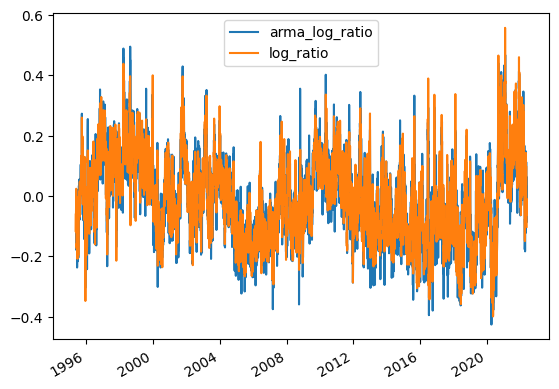

In [20]:
df_preds[['arma_log_ratio', 'log_ratio']].plot()

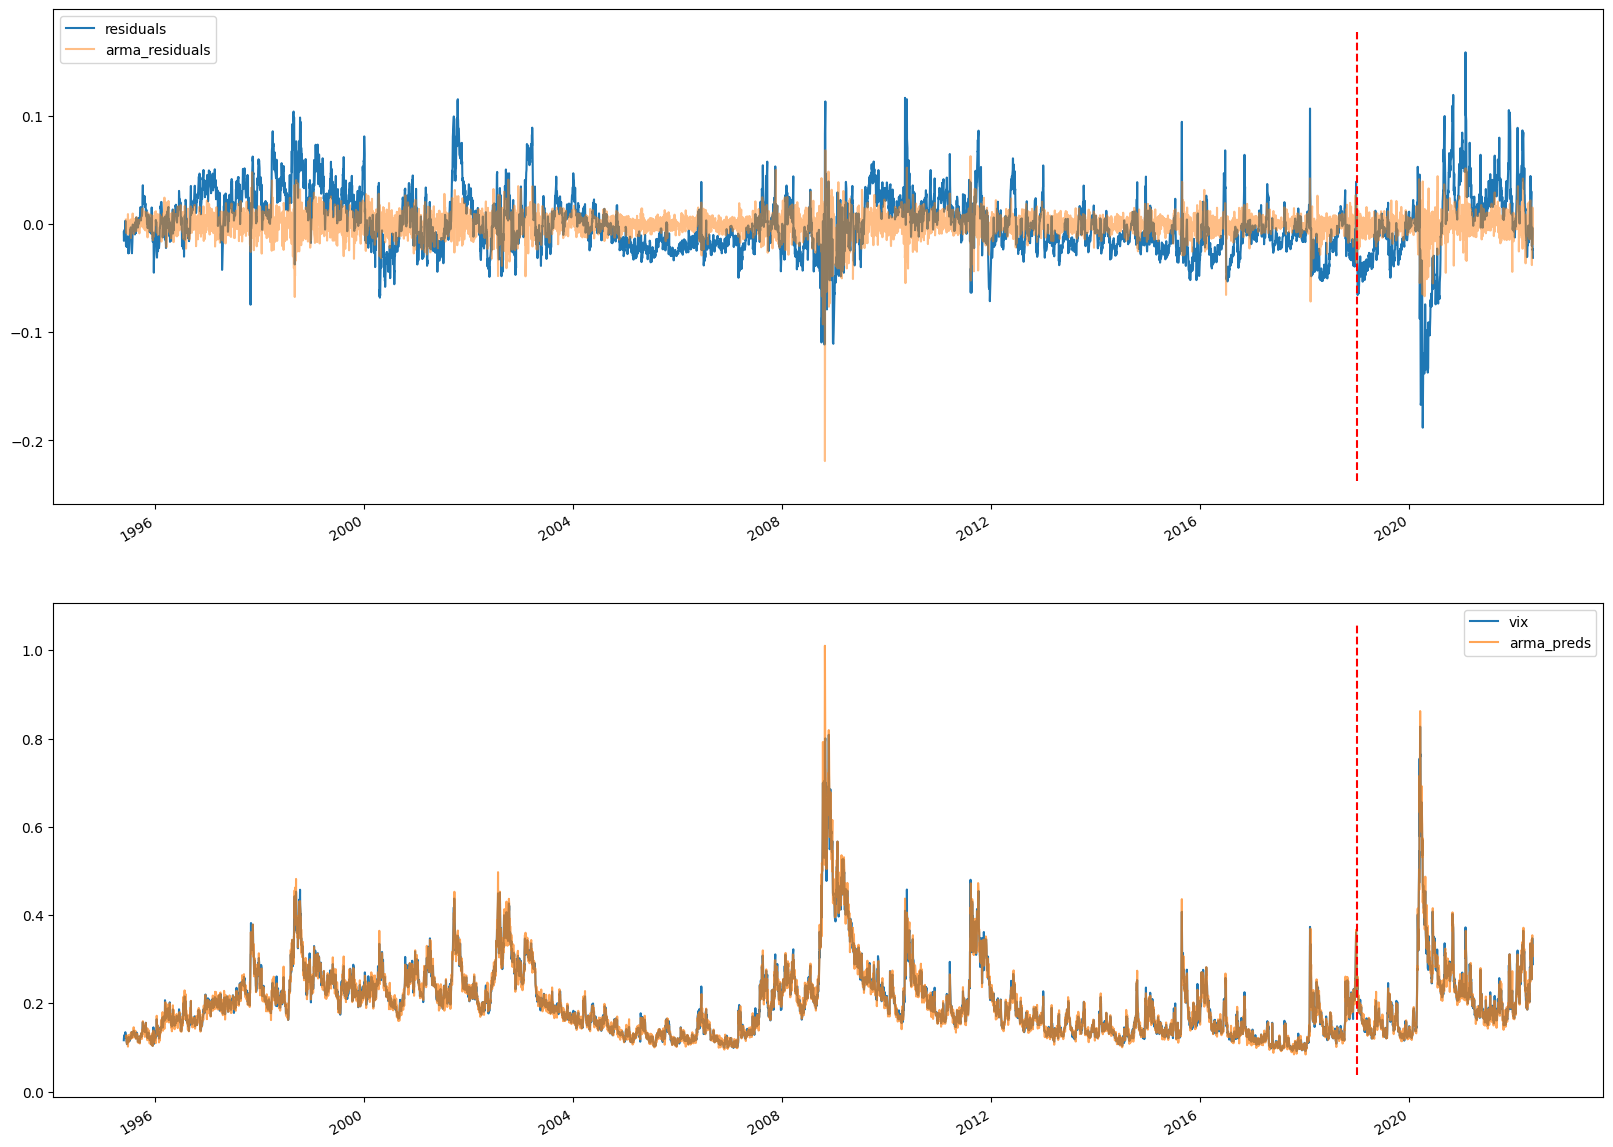

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

df_preds[['residuals']].plot(ax=ax[0])
df_preds[['arma_residuals']].plot(ax=ax[0], alpha=0.5)
df_preds[['vix']].plot(ax=ax[1])
df_preds[['arma_preds']].plot(ax=ax[1], alpha=0.7)
ax[0].vlines(test_start_date, ax[0].get_ylim()[0], ax[0].get_ylim()[-1], linestyles='dashed', colors='red')
ax[1].vlines(test_start_date, ax[1].get_ylim()[0], ax[1].get_ylim()[-1], linestyles='dashed', colors='red')

<Axes: >

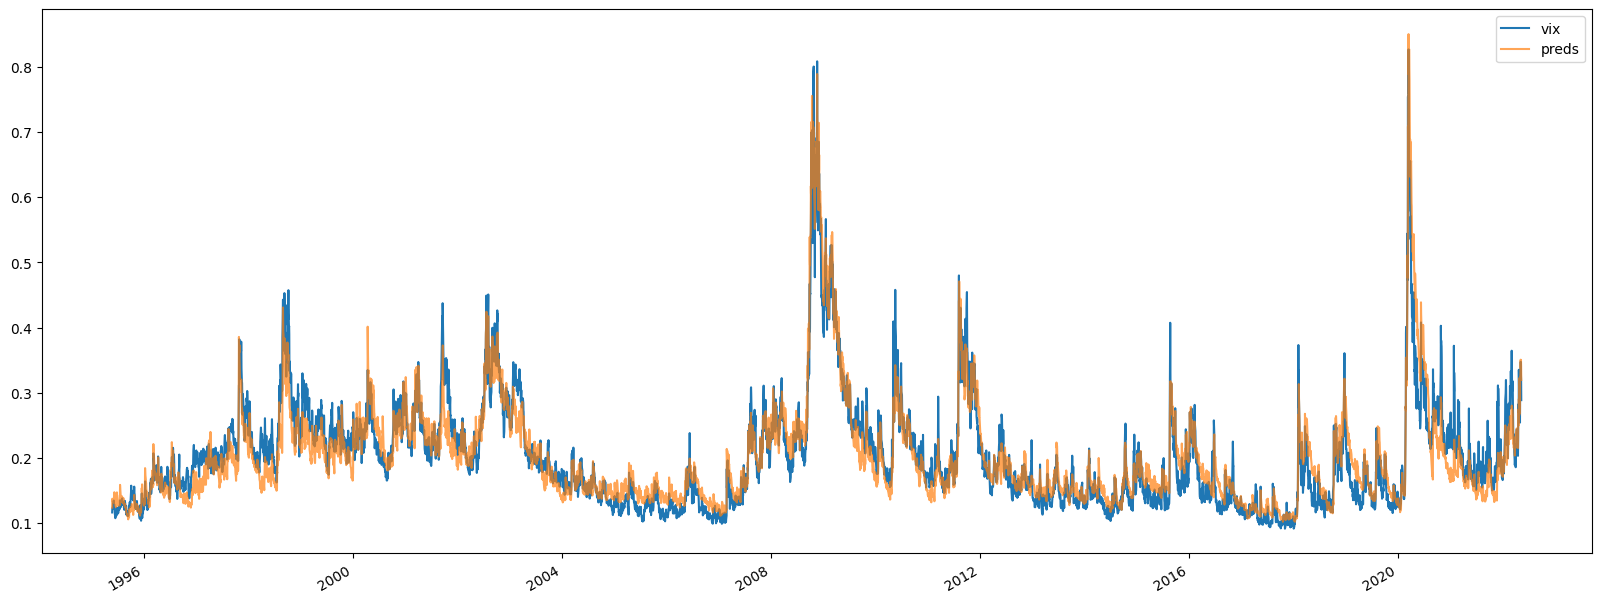

In [22]:
ax = df_preds[['vix']].plot(figsize=(20, 8))
df_preds[['preds']].plot(ax=ax, alpha=0.7)

## Forecast 5000 steps ahead starting from the last available data point

In [23]:
if use_vix_exog == False:
    preds = predict(*res.x, full_data, window)
    df_preds = full_data[window-1:].copy() # remove data used to calculate first PDV prediction
    df_preds['vix_shift'] = df_preds['vix'].shift(1) # shift use that time t-1 vix is used to predict residual for time t
    df_preds['preds'] = preds
    df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
    df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
    df_preds['log_ratio'] = np.log(df_preds['ratio'])
    df_preds

In [24]:
if use_vix_exog == False:
    n_sims = 12 # number of simulations
    y = df_preds['log_ratio'][1:] if use_log_ratio else df_preds['ratio'][1:] # drop the first row because vix_shift is nan
    x = df_preds['vix_shift'][1:]
    if use_vix_exog:
        arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
    else:
        arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
    arma_model_test.distribution = ARCHNormal(seed=seed) # set seed for reproducibility
    fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
    if use_vix_exog:
        sims = fix_res.forecast(horizon=5000, method='simulation', simulations=n_sims, align='origin', x=x) # with vix as exogenous variable
    else:
        sims = fix_res.forecast(horizon=5000, method='simulation', simulations=n_sims, align='origin') # without vix as exogenous variable
    print(sims.simulations.values.shape)
    log_residuals = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
    log_residuals.shape

In [25]:
if use_vix_exog == False:
    fig, ax = plt.subplots(n_sims//3, 3, figsize=(20, 8))
    for i in range(n_sims//3):
        for j in range(3):
            ax[i, j].plot(log_residuals[i*3+j, :]);
    plt.tight_layout();

In [26]:
if use_vix_exog == False:
    print(f'Long run mean of log ratio residuals: {arma_res.params[0] / (1 - arma_res.params[1])}')
    print(f'Long run variance of log ratio residuals: {arma_res.params[0]**2 / (1 - arma_res.params[1]**2)}')
    print(f'Long run mean of ratio residuals: {np.exp(arma_res.params[0] / (1 - arma_res.params[1]))}')

## Forecast the full data after starting after the res_window observations using actual historical SPX data and simulated VIX data

In [27]:
preds = predict(*res.x, full_data, window)
df_preds = full_data[window-1:].copy() # remove data used to calculate first PDV prediction
df_preds['vix_shift'] = df_preds['vix'].shift(1) # shift use that time t-1 vix is used to predict residual for time t
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds.dropna(inplace=True) # drop the first row because vix_shift is nan
df_preds.iloc[max_lag:, -1] = np.NaN
print(f'n_lags: {n_lags}, res_window: {res_window}, max_lag: {max_lag}')
# df_preds.loc[df_preds.index[max_lag-1]:,:]

# # FOR TESTING CUT DF LENGTH
# df_preds = df_preds.iloc[:max_lag+20, :]
# df_preds

n_lags: 5, res_window: 10, max_lag: 10


In [30]:
indices = []
for i in range(100, 0, -1):
    indices.append(df_preds.index[0] - pd.Timedelta(days=i))
temp_df = pd.DataFrame(np.zeros((100, df_preds.shape[1])), columns=df_preds.columns, index=indices)
#temp_df to pad df_preds else arma_model_test.fix() might fail due to insufficient data points even though no estimation is done

if use_vix_exog:
    log_residuals = []
    saved_state = None
    for i in range(n_sims):
        y = df_preds['log_ratio'][:max_lag] if use_log_ratio else df_preds['ratio'][:max_lag]
        y = pd.concat([temp_df['log_ratio'], y]).values # pad temp_df to avoid insufficient data points error
        x = df_preds['vix_shift'][:max_lag]
        x = pd.concat([temp_df['vix_shift'], x]).values # pad temp_df to avoid insufficient data points error
        arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
        arma_model_test.distribution = ARCHNormal(seed=seed) if saved_state is None else ARCHNormal(seed=saved_state) # set seed for reproducibility
        fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
        sims = fix_res.forecast(horizon=1,method='simulation', simulations=1, align='origin', x=x[:,np.newaxis]) # with vix as exogenous variable
        next_y = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
        vix = df_preds.iloc[max_lag, df_preds.columns.get_loc('vix_shift')]
        # print(f'vix: {vix}')
        x = np.concatenate([x, [vix]])
        idx = max_lag
        while idx < len(df_preds):
            # print(f'y.shape: {y.shape}, next_y.shape: {next_y.shape}')
            pred = df_preds.iloc[idx, df_preds.columns.get_loc('preds')]
            vix = pred * np.exp(next_y) if use_log_ratio else pred * next_y # vix at row max_lag = PDV prediction * np.exp(log_ratio) (both also at row max_lag)
            # df_preds.iloc[idx, df_preds.columns.get_loc('arma_multi_step_vix')] = vix # NOTE: for debugging
            # print(f'pred: {pred}, ratio: {np.exp(next_y) if use_log_ratio else next_y}, vix: {vix}, log_ratio: {next_y}')
            y = np.concatenate([y, [next_y]])
            arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False, x=x) # with vix as exogenous variable
            fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
            sims = fix_res.forecast(horizon=1, method='simulation', simulations=1, align='origin', x=x[:,np.newaxis])
            next_y = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
            # print(f'x.shape: {x.shape}, vix.shape: {vix.shape}')
            x = np.concatenate([x, [vix]])
            idx += 1
        log_residuals.append(y[len(temp_df)+max_lag:] if use_log_ratio else np.log(y[len(temp_df)+max_lag:])) # remove the padded and the first max_lag rows
        # saved_state = arma_model_test.distribution.random_state # random_state is deprecated
        saved_state = np.random.default_rng(saved_state)
    log_residuals = np.array(log_residuals)
    print(log_residuals.shape)
else:
    y = df_preds['log_ratio'][:max_lag] if use_log_ratio else df_preds['ratio'][:max_lag]
    y = pd.concat([temp_df['log_ratio'], y]) # pad temp_df to avoid insufficient data points error
    arma_model_test = arch.arch_model(y=y, mean='ARX', vol='ARCH', lags=n_lags, p=res_window, rescale=False) # without vix as exogenous variable
    arma_model_test.distribution = ARCHNormal(seed=seed) # set seed for reproducibility
    fix_res = arma_model_test.fix(arma_res.params) # fix the parameters based on fitting on full data
    sims = fix_res.forecast(horizon=len(df_preds)-max_lag, method='simulation', simulations=n_sims, align='origin') # without vix as exogenous variable
    print(sims.simulations.values.shape)
    log_residuals = sims.simulations.values.squeeze() if use_log_ratio else np.log(sims.simulations.values.squeeze()) # (timestep, simulations, horizon)
    print(log_residuals.shape)

(2, 6780)


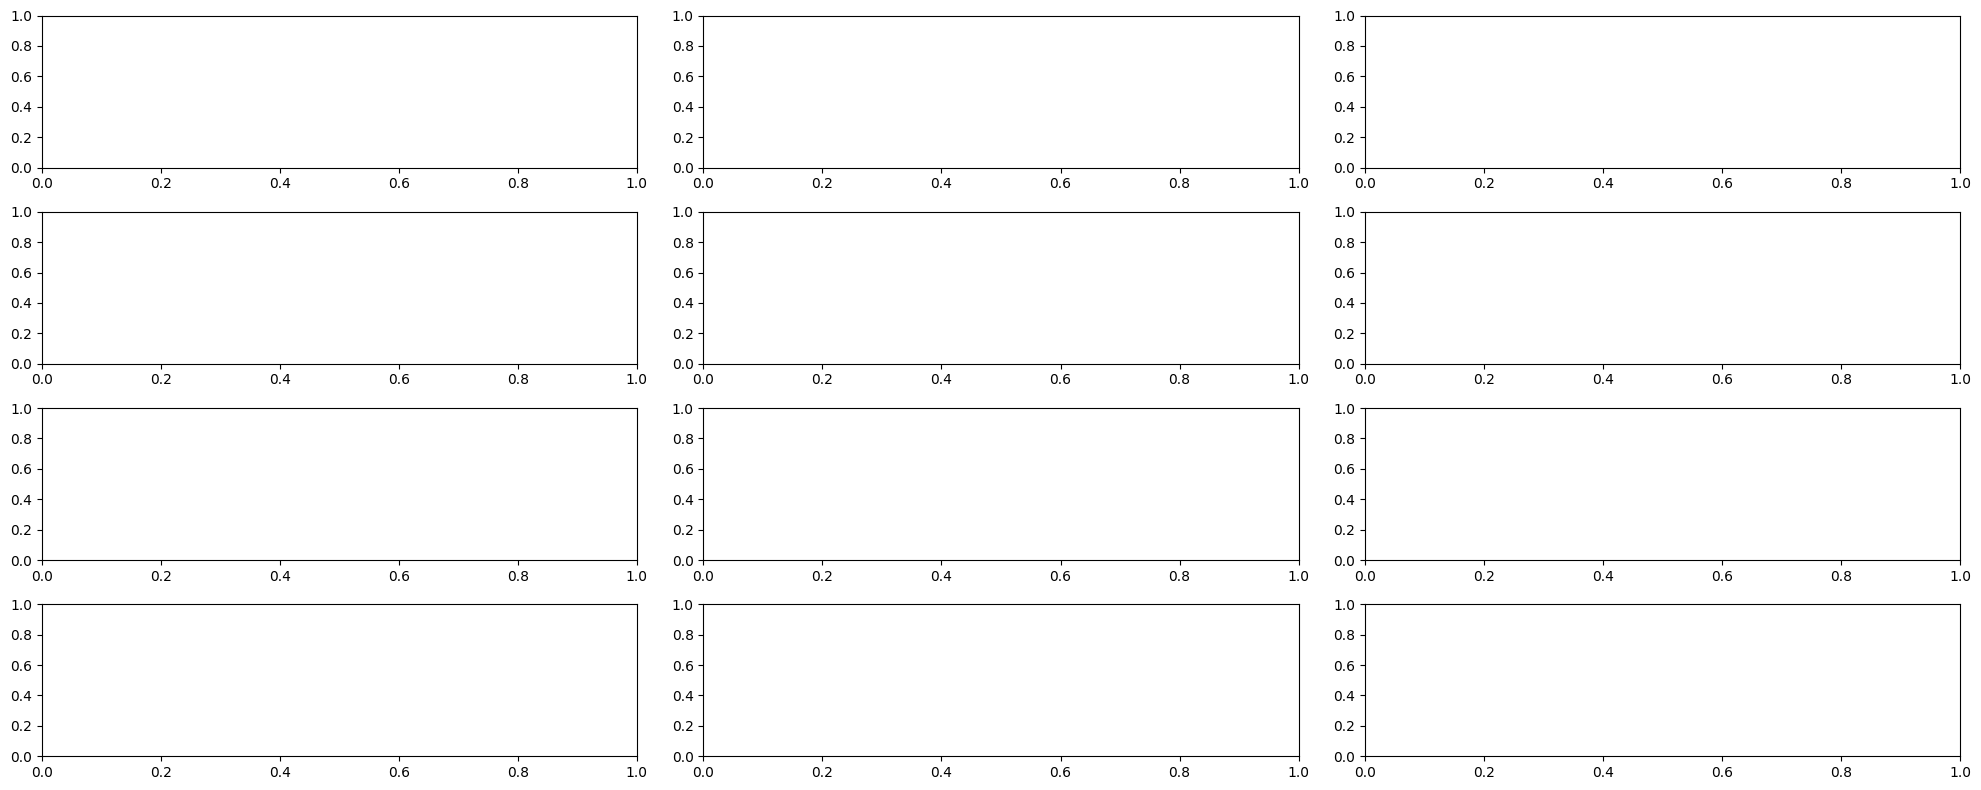

In [31]:
fig, ax = plt.subplots(4, 3, figsize=(20, 8))
for i in range(n_sims//3):
    for j in range(3):
        ax[i, j].plot(log_residuals[i*3+j, :]);
plt.tight_layout();

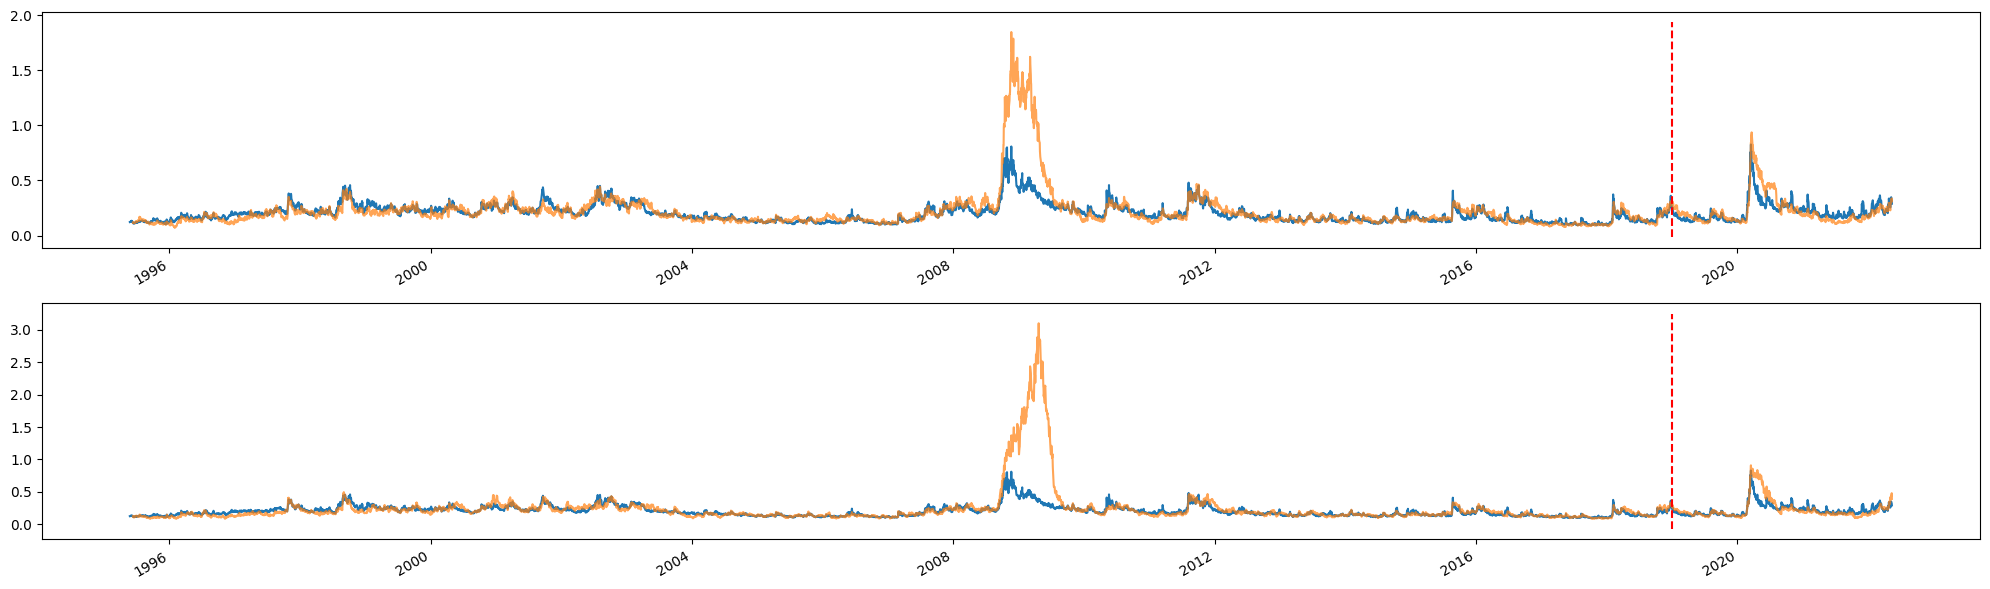

In [32]:
fig, ax = plt.subplots(n_sims, 1, figsize=(20, n_sims*3))
for i in range(n_sims):
    df_preds['arma_multi_step_log_ratio'] = np.NaN
    df_preds.iloc[max_lag:, df_preds.columns.get_loc('arma_multi_step_log_ratio')] = log_residuals[i, :]
    df_preds['arma_multi_step_preds'] = np.exp(df_preds['arma_multi_step_log_ratio']) * df_preds['preds']
    df_preds['arma_multi_step_residuals'] = df_preds['vix'] - df_preds['arma_multi_step_preds']
    df_preds['vix'].plot(ax=ax[i], alpha=1.0)
    df_preds['arma_multi_step_preds'].plot(ax=ax[i], alpha=0.7)
    ax[i].vlines(test_start_date, ax[i].get_ylim()[0], ax[i].get_ylim()[-1], linestyles='dashed', colors='red')
plt.tight_layout();

In [80]:
df_preds[max_lag-2:]

,r1,r2,vix,vix_shift,preds,residuals,ratio,log_ratio,arma_multi_step_log_ratio,arma_multi_step_preds,arma_multi_step_residuals
1995-06-08,-0.001464,2.143835e-06,0.1289,0.1284,0.136857,-0.007957,0.941860,-0.059898,NaN,NaN,NaN
1995-06-09,-0.008318,6.919705e-05,0.1276,0.1289,0.147304,-0.019704,0.866233,-0.143601,NaN,NaN,NaN
1995-06-12,0.005553,3.083993e-05,0.1191,0.1276,0.138616,-0.019516,0.859207,NaN,0.056220,0.146632,-0.027532
1995-06-13,0.009691,9.392326e-05,0.1129,0.1191,0.133783,-0.020883,0.843901,NaN,0.041934,0.139513,-0.026613
1995-06-14,0.000783,6.133558e-07,0.1129,0.1129,0.132824,-0.019924,0.849996,NaN,0.045140,0.138957,-0.026057
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.3019,0.350728,-0.003228,0.990797,NaN,0.013974,0.355663,-0.008163
2022-05-10,0.002455,6.026444e-06,0.3299,0.3475,0.338454,-0.008554,0.974726,NaN,0.002986,0.339466,-0.009566
2022-05-11,-0.016600,2.755677e-04,0.3256,0.3299,0.349547,-0.023947,0.931490,NaN,0.044991,0.365633,-0.040033
2022-05-12,-0.001297,1.681703e-06,0.3177,0.3256,0.340538,-0.022838,0.932936,NaN,0.163209,0.400909,-0.083209
